(-0.5, 5279.5, 3955.5, -0.5)

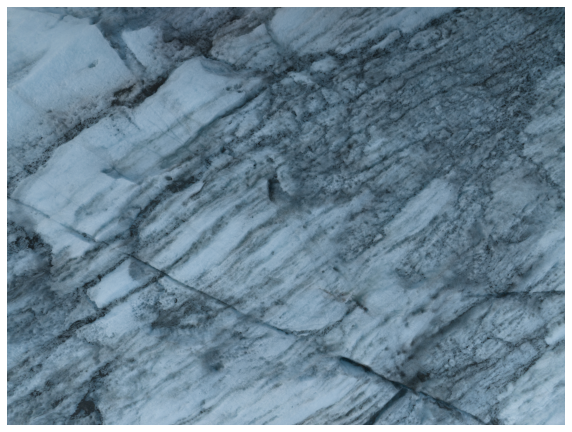

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]


image = Image.open('data/DJI_20230715091030_0013_D.jpg')
plt.imshow(image, cmap='Greys_r')
plt.axis('off')

# 1. Distribution of pixels

In [2]:
data = np.array(image, dtype=np.int32)

data_r, data_g, data_b = data[:, :, 0], data[:, :, 1], data[:, :, 2]
data_flat = data.flatten()

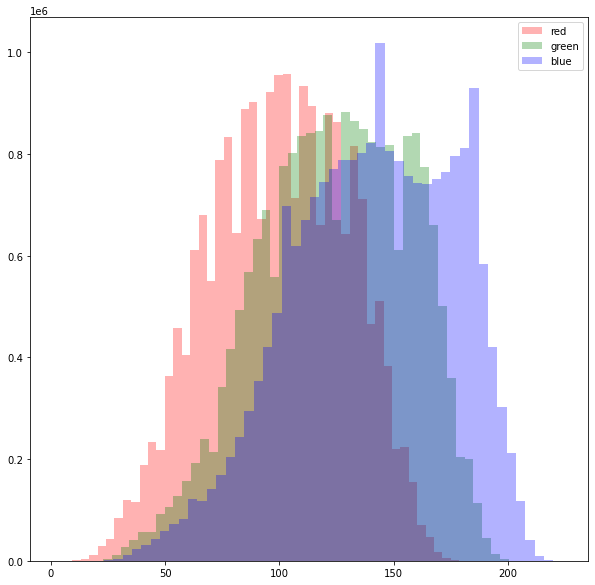

In [3]:
plt.hist(data_r.flatten(), label='red', color='red', alpha=0.3, bins=50)
plt.hist(data_g.flatten(), label='green', color='green', alpha=0.3, bins=50)
plt.hist(data_b.flatten(), label='blue', color='blue', alpha=0.3, bins=50)
plt.legend()

# 2. Differential Entropy

https://stats.stackexchange.com/questions/235270/entropy-of-an-image

https://arxiv.org/ftp/arxiv/papers/1609/1609.01117.pdf

In [4]:
def differentiate(d, axis=0):
    # differential data
    d_diff = (np.roll(d, 1, axis=axis) - d)[1:-1, 1:-1]
    return d_diff

def entropy(labels, axis=None):
    value, counts = np.unique(labels, axis=axis, return_counts=True)
    norm_counts = counts / counts.sum()
    return -(norm_counts * np.log(norm_counts)).sum()

In [5]:
def H_image(d):
    d_x, d_y = differentiate(d, axis=0), differentiate(d, axis=1)
    d_xy = np.stack([d_x, d_y], axis=2)
    d_xy = d_xy.reshape((d_xy.shape[0] * d_xy.shape[1], 2))
    return (2/3) * entropy(d_xy, axis=0)
    

In [6]:
random_noise = np.random.randint(low=0, high=255, size=data_r.shape)
print(f'Random noise entropy: {H_image(random_noise)}')

uniform_image = np.ones(data_r.shape, dtype=np.int32)
print(f'Uniform image entropy: {H_image(uniform_image)}')


print(f'Drone image red channel entropy: {H_image(data_r)}')
print(f'Drone image green channel entropy: {H_image(data_g)}')
print(f'Drone image blue channel entropy: {H_image(data_b)}')

Random noise entropy: 7.94074374591271
Uniform image entropy: -0.0
Drone image red channel entropy: 3.7707272297583456
Drone image green channel entropy: 3.787278617369286
Drone image blue channel entropy: 3.8247085957487155


## 3. Comparing 2 images

More ice => More uniform image => Lower entropy

<Figure size 720x720 with 0 Axes>

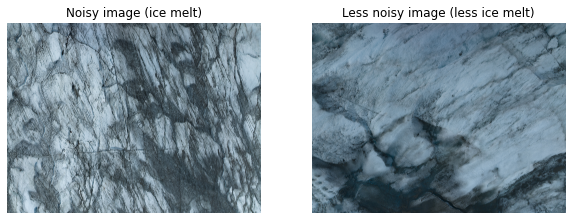

In [7]:
image_noisy = Image.open('data/noisy.jpg')
image_less_noisy = Image.open('data/less_noisy.jpg')

plt.figure()
fig, ax = plt.subplots(1, 2) 

ax[0].imshow(image_noisy, cmap='Greys_r')
ax[0].title.set_text('Noisy image (ice melt)')
ax[1].imshow(image_less_noisy, cmap='Greys_r')
ax[1].title.set_text('Less noisy image (less ice melt)')

ax[0].axis('off')
ax[1].axis('off')

plt.show()

In [8]:
data_noisy = np.array(image_noisy, dtype=np.int32)
data_r, data_g, data_b = data_noisy[:, :, 0], data_noisy[:, :, 1], data_noisy[:, :, 2]
print(f'Entropy for noisy image: {H_image(data_r)}')

data_less_noisy = np.array(image_less_noisy, dtype=np.int32)
data_r, data_g, data_b = data_less_noisy[:, :, 0], data_less_noisy[:, :, 1], data_less_noisy[:, :, 2]
print(f'Entropy for less noisy image: {H_image(data_r)}')

Entropy for noisy image: 4.022328853749157
Entropy for less noisy image: 3.8050695075368943
